In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

In [2]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [3]:
df = pd.read_csv('final_walm.csv', parse_dates=[0], index_col= 0, date_parser=parser)
df.head()

/tmp/ipykernel_5696/3722882470.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('final_walm.csv', parse_dates=[0], index_col= 0, date_parser=parser)


,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,is_holiday,pre_holiday,post_holiday,Weekly_Sales_MA30,holiday_sales_impact,temp_fuel_interaction,Day,Lag1_Day
Date,,,,,,,,,,,,,,,
2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,0,0,0,1.576836e+06,0.0,119.41943,26,NaN
2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,0,0,0,1.554615e+06,0.0,122.06250,5,26.0
2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,0,0,0,1.504011e+06,0.0,154.12593,12,5.0
2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,3,0,0,0,1.469148e+06,0.0,148.45760,19,12.0
2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,3,0,0,0,1.467823e+06,0.0,140.56140,26,19.0


In [4]:
# it determines M D or Y in steps automaticaly
df = df.asfreq(pd.infer_freq(df.index))

In [5]:
df.index

DatetimeIndex(['2010-02-26', '2010-03-05', '2010-03-12', '2010-03-19',
               '2010-03-26', '2010-04-02', '2010-04-09', '2010-04-16',
               '2010-04-23', '2010-04-30',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=140, freq='W-FRI')

# CrossV test/train split

In [6]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=5)
df = df.sort_index()

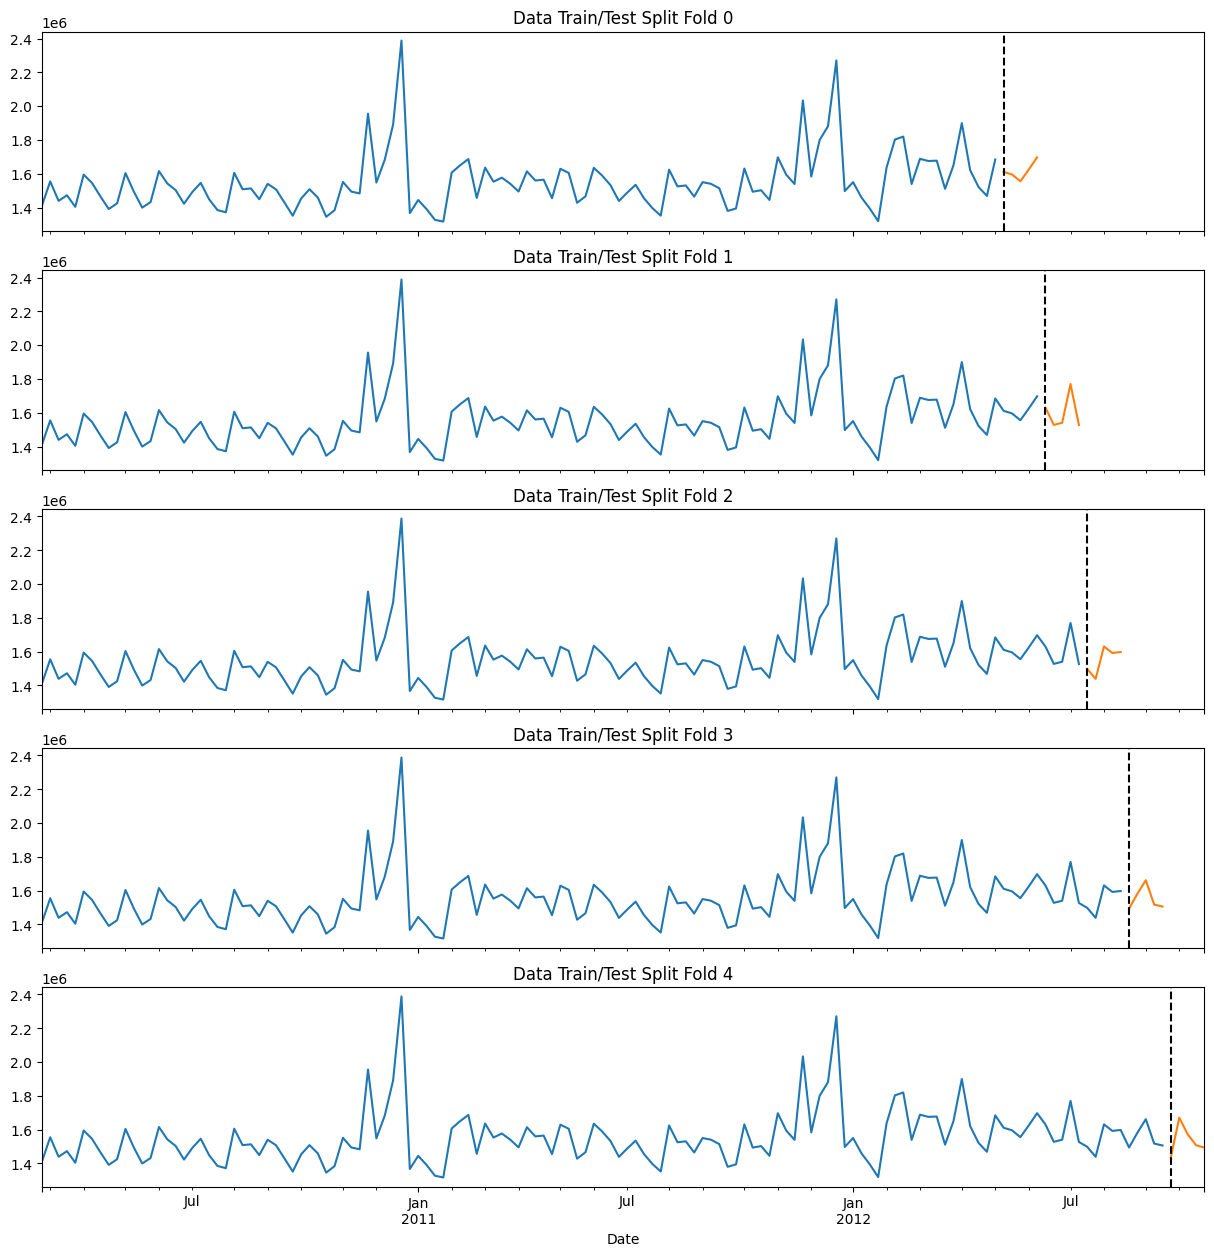

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Weekly_Sales'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Weekly_Sales'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Train/test split

In [8]:
train = df.loc[df.index < '2012-09-28']
test = df.loc[df.index >= '2012-09-28']

In [9]:
train.head()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,is_holiday,pre_holiday,post_holiday,Weekly_Sales_MA30,holiday_sales_impact,temp_fuel_interaction,Day,Lag1_Day
Date,,,,,,,,,,,,,,,
2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,0,0,0,1.576836e+06,0.0,119.41943,26,NaN
2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,0,0,0,1.554615e+06,0.0,122.06250,5,26.0
2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,0,0,0,1.504011e+06,0.0,154.12593,12,5.0
2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,3,0,0,0,1.469148e+06,0.0,148.45760,19,12.0
2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,3,0,0,0,1.467823e+06,0.0,140.56140,26,19.0


# Train the model with CrossV

In [10]:
scores=[]
FEATURES = ['Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment',	'Month','is_holiday','pre_holiday','post_holiday','Weekly_Sales_MA30','holiday_sales_impact','temp_fuel_interaction','Day','Lag1_Day']
TARGET = ['Weekly_Sales']

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


    predictions = reg.predict(X_test)
    score = np.sqrt(root_mean_squared_error(y_test, predictions))
    scores.append(score)

[0]	validation_0-rmse:1543637.14779	validation_1-rmse:1602137.55250
[100]	validation_0-rmse:589790.90982	validation_1-rmse:624870.28935
[200]	validation_0-rmse:242244.84915	validation_1-rmse:255267.42061
[300]	validation_0-rmse:113499.93120	validation_1-rmse:122610.16999
[400]	validation_0-rmse:65280.94403	validation_1-rmse:77408.25515
[500]	validation_0-rmse:48219.78883	validation_1-rmse:63372.44115
[600]	validation_0-rmse:40170.02567	validation_1-rmse:55091.14229
[639]	validation_0-rmse:38109.81007	validation_1-rmse:56453.65879
[0]	validation_0-rmse:1546085.80141	validation_1-rmse:1586518.08422
[100]	validation_0-rmse:589810.44180	validation_1-rmse:602050.55741
[200]	validation_0-rmse:241334.52091	validation_1-rmse:239221.00092
[300]	validation_0-rmse:111602.12032	validation_1-rmse:105064.23615
[400]	validation_0-rmse:64519.51741	validation_1-rmse:65889.88358
[500]	validation_0-rmse:47659.21003	validation_1-rmse:56327.30367
[600]	validation_0-rmse:40117.15349	validation_1-rmse:49203.

In [11]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 198.0391
Fold scores:[233.32810554886217, 209.84887091473107, 183.0284263404628, 225.15806516191768, 138.83209510198867]


In [12]:
predictions

array([1449328. , 1651843.2, 1552339.6, 1537862.6, 1499192.9],
      dtype=float32)

In [13]:
predictions_df = pd.Series(predictions, index=y_test.index)

Text(0, 0.5, 'Sales in millions')

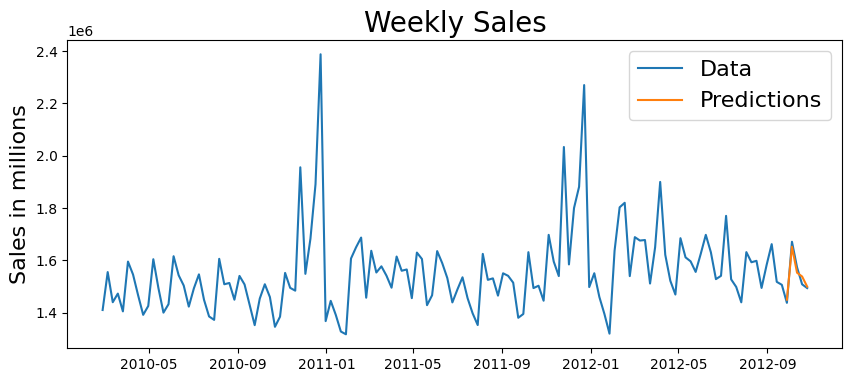

In [14]:
plt.figure(figsize=(10,4))

plt.plot(df['Weekly_Sales'])
plt.plot(predictions_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Weekly Sales', fontsize=20)
plt.ylabel('Sales in millions', fontsize=16)

In [15]:
y_test

,Weekly_Sales
Date,
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81
2012-10-19,1508068.77
2012-10-26,1493659.74


predictions_df = pd.Series(predictions, index=y_test.index)  # Same index
predictions_df

In [16]:
y_nu_test = y_test['Weekly_Sales']
y_nu_test

Date
2012-09-28    1437059.26
2012-10-05    1670785.97
2012-10-12    1573072.81
2012-10-19    1508068.77
2012-10-26    1493659.74
Freq: W-FRI, Name: Weekly_Sales, dtype: float64

In [17]:
rmse = root_mean_squared_error(y_test, predictions)
print(f"Rmse: {rmse}")

# МAPE
mape = np.mean(np.abs((y_nu_test - predictions) / y_nu_test)) * 100
print(f"MAPE for XGB: {mape:.2f}%")

Rmse: 19274.35063040763
MAPE for XGB: 1.13%


# The best model at this point has 1,13% MAPE